    Stain separation matrices available in the ``color`` module and their
    respective colorspace:

    * ``hed_from_rgb``: Hematoxylin + Eosin + DAB
    * ``hdx_from_rgb``: Hematoxylin + DAB
    * ``fgx_from_rgb``: Feulgen + Light Green
    * ``bex_from_rgb``: Giemsa stain : Methyl Blue + Eosin
    * ``rbd_from_rgb``: FastRed + FastBlue +  DAB
    * ``gdx_from_rgb``: Methyl Green + DAB
    * ``hax_from_rgb``: Hematoxylin + AEC
    * ``bro_from_rgb``: Blue matrix Anilline Blue + Red matrix Azocarmine\
                        + Orange matrix Orange-G
    * ``bpx_from_rgb``: Methyl Blue + Ponceau Fuchsin
    * ``ahx_from_rgb``: Alcian Blue + Hematoxylin
    * ``hpx_from_rgb``: Hematoxylin + PAS

In [1]:
from skimage.color.colorconv import ahx_from_rgb,hpx_from_rgb,bpx_from_rgb,bro_from_rgb,hax_from_rgb,gdx_from_rgb,rbd_from_rgb,bex_from_rgb,fgx_from_rgb,hdx_from_rgb,hed_from_rgb,separate_stains
import cv2
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndi

In [2]:
def read_img_mask(image_idx, original=False):
    if original:
        retinex_path = f'rf_trained_pred/original/{str(image_idx).zfill(4)}_original.jpg'
    else:
        retinex_path = f'rf_trained_pred/retinex/{str(image_idx).zfill(4)}_retinex.jpg'
    mask_path = f'rf_trained_pred/processed_mask/{str(image_idx).zfill(4)}_mask.jpg'
    mask2_path = f'rf_trained_pred/raw_mask/{str(image_idx).zfill(4)}_raw_mask.jpg'
    image = cv2.imread(retinex_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask[mask > 0] = 1
    mask2 = cv2.imread(mask2_path, cv2.IMREAD_GRAYSCALE)
    mask2[mask2 > 0] = 1
    return image, mask, mask2

def extract_img(image, mask):
    return cv2.bitwise_and(image, image, mask=mask.astype(np.uint8))

def process_channel(channel):
    channel[channel>0]=1
    channel = cv2.dilate(channel, np.ones((3,3), np.uint8), iterations=1)
    channel = ndi.binary_fill_holes(channel)
    # channel = cv2.erode(channel, np.ones((3,3), np.uint8), iterations=5)
    channel = cv2.morphologyEx(channel.astype(np.uint8), cv2.MORPH_HITMISS, np.ones((3,3), np.uint8), iterations=5)
    channel = cv2.morphologyEx(channel.astype(np.uint8), cv2.MORPH_CROSS, np.ones((3,3), np.uint8), iterations=5)
#     channel = cv2.morphologyEx(channel.astype(np.uint8), cv2.MORPH_GRADIENT, np.ones((3,3), np.uint8), iterations=5)
    channel = cv2.morphologyEx(channel.astype(np.uint8), cv2.MORPH_CLOSE, np.ones((3,3), np.uint8), iterations=5)
    channel = ndi.binary_fill_holes(channel)
    channel = cv2.morphologyEx(channel.astype(np.uint8), cv2.MORPH_OPEN, np.ones((3,3), np.uint8), iterations=20)
    # channel = cv2.morphologyEx(channel.astype(np.uint8), cv2.MORPH_CLOSE, np.ones((3,3), np.uint8), iterations=5)
    # channel = cv2.morphologyEx(channel.astype(np.uint8), cv2.MORPH_CROSS, np.ones((3,3), np.uint8), iterations=5)
    return channel

def plot_channels(image, channels):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for i, (channel, name) in enumerate(zip(cv2.split(channels), ["C1", "C2", "C3"])):
        channel = process_channel(channel)
        channel = extract_img(image, channel)
        axes[i].imshow(channel)
        axes[i].set_title(f'{name} Channel ({channel.min()}-{channel.max()})')
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()

def process_rf_mask(mask):
    mask = mask.astype(np.uint8)
    mask = ndi.binary_fill_holes(mask)
    mask = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_OPEN, np.ones((3,3), np.uint8), iterations=5)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((3,3), np.uint8), iterations=5)
    return mask

def plot_current_masks(image, mask, mask2):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    proc_mask = extract_img(image, mask)
    axes[0].imshow(proc_mask)
    axes[0].set_title("Processed Mask")
    axes[0].axis("off")
    rf_mask = process_rf_mask(mask2)
    rf_mask = extract_img(image, rf_mask)
    axes[1].imshow(rf_mask)
    axes[1].set_title("Raw Mask")
    axes[1].axis("off")
    plt.tight_layout()
    plt.show()
    
def get_stain_vector(StainingVectorID):
       """
       StainingVectorID: Index
       1  = "H&E"
       2  = "H&E 2"
       3  = "H DAB"
       4  = "H&E DAB"
       5  = "NBT/BCIP Red Counterstain II"
       6  = "H DAB NewFuchsin"
       7  = "H HRP-Green NewFuchsin"
       8  = "Feulgen LightGreen"
       9  = "Giemsa"
       10 = "FastRed FastBlue DAB"
       11 = "Methyl Green DAB"
       12 = "H AEC"
       13 = "Azan-Mallory"
       14 = "Masson Trichrome"
       15 = "Alcian Blue & H"
       16 = "H PAS"
       17 = "Brilliant_Blue"
       18 = "AstraBlue Fuchsin"
       19 = "RGB"
       20 = "ROI Based Extraction"
       """
       if StainingVectorID==1:
              MODx = [0.644211, 0.092789, 0];
              MODy = [0.716556, 0.954111, 0];
              MODz = [0.266844, 0.283111, 0];
       elif StainingVectorID==2:
              MODx = [0.49015734, 0.04615336, 0];
              MODy = [0.76897085, 0.8420684, 0];
              MODz = [0.41040173, 0.5373925, 0];
       elif StainingVectorID==3:
              MODx = [0.650, 0.268, 0];
              MODy = [0.704, 0.570, 0];
              MODz = [0.286, 0.776, 0];
       elif StainingVectorID==4:
              MODx = [0.650, 0.072, 0.268];
              MODy = [0.704, 0.990, 0.570];
              MODz = [0.286, 0.105, 0.776];
       elif StainingVectorID==5:
              MODx = [0.62302786, 0.073615186, 0.7369498];
              MODy = [0.697869, 0.79345673, 0.0010];
              MODz = [0.3532918, 0.6041582, 0.6759475];
       elif StainingVectorID==6:
              MODx = [0.5625407925, 0.26503363, 0.0777851125];
              MODy = [0.70450559, 0.68898016, 0.804293475];
              MODz = [0.4308375625, 0.674584, 0.5886050475];
       elif StainingVectorID==7:
              MODx = [0.8098939567, 0.0777851125, 0.0];
              MODy = [0.4488181033, 0.804293475, 0.0];
              MODz = [0.3714423567, 0.5886050475, 0.0];
       elif StainingVectorID==8:
              MODx = [0.46420921, 0.94705542, 0.0];
              MODy = [0.83008335, 0.25373821, 0.0];
              MODz = [0.30827187, 0.19650764, 0.0];
       elif StainingVectorID==9:
              MODx = [0.834750233, 0.092789, 0.0];
              MODy = [0.513556283, 0.954111, 0.0];
              MODz = [0.196330403, 0.283111, 0.0];
       elif StainingVectorID==10:
              MODx = [0.21393921, 0.74890292, 0.268];
              MODy = [0.85112669, 0.60624161, 0.570];
              MODz = [0.47794022, 0.26731082, 0.776];
       elif StainingVectorID==11:
              MODx = [0.98003, 0.268, 0.0];
              MODy = [0.144316, 0.570, 0.0];
              MODz = [0.133146, 0.776, 0.0];
       elif StainingVectorID==12:
              MODx = [0.650, 0.2743, 0.0];
              MODy = [0.704, 0.6796, 0.0];
              MODz = [0.286, 0.6803, 0.0];
       elif StainingVectorID==13:
              MODx = [0.853033, 0.09289875, 0.10732849];
              MODy = [0.508733, 0.8662008, 0.36765403];
              MODz = [0.112656, 0.49098468, 0.9237484];
       elif StainingVectorID==14:
              MODx = [0.7995107, 0.09997159, 0.0];
              MODy = [0.5913521, 0.73738605, 0.0];
              MODz = [0.10528667, 0.6680326, 0.0];
       elif StainingVectorID==15:
              MODx = [0.874622, 0.552556, 0.0];
              MODy = [0.457711, 0.7544, 0.0];
              MODz = [0.158256, 0.353744, 0.0];
       elif StainingVectorID==16:
              MODx = [0.644211, 0.175411, 0.0];
              MODy = [0.716556, 0.972178, 0.0];
              MODz = [0.266844, 0.154589, 0.0];
       elif StainingVectorID==17:
              MODx = [0.31465548, 0.383573, 0.7433543];
              MODy = [0.6602395, 0.5271141, 0.51731443];
              MODz = [0.68196464, 0.7583024, 0.4240403];
       elif StainingVectorID==18:
              MODx = [0.92045766, 0.13336428, 0.0];
              MODy = [0.35425216, 0.8301452, 0.0];
              MODz = [0.16511545, 0.5413621, 0.0];
       elif StainingVectorID==19:
              MODx = [0.001, 1.0, 1.0];
              MODy = [1.0, 0.001, 1.0];
              MODz = [1.0, 1.0, 0.001];
       elif StainingVectorID==20:
              MODx =[ 0.22777562, 0.55556387, 0.7996668 ]
              MODy =[0.035662863,  0.08113831, 0.9960646]
              MODz =[ 0.7617831, 0.6478321 ,  0.001]
       else:
              MODx = [1.0, 0.0, 0.0];
              MODy = [0.0, 1.0, 0.0];
              MODz = [0.0, 0.0, 1.0];
       eps = 1e-5
       stain_vectors = np.array([MODx, MODy, MODz]).T
       # Check 2nd Channel is missing
       if all([x==0.0 for x in stain_vectors[1,:]]):
              stain_vectors[1,:] = stain_vectors[0,:][[2,0,1]]
       # Check 3rd Channel is missing
       if all([x==0.0 for x in stain_vectors[2,:]]):
              stain_vectors[2,:] = np.cross(stain_vectors[0,:] , stain_vectors[1,:])
       return np.linalg.inv(stain_vectors)

def background_removal_dog(brightfield_img, kernel1=15, kernel2=50):
    """Remove background using the Difference of Gaussian (DoG) method."""
    # Apply Gaussian blur with two different kernel sizes
    blurred1 = cv2.GaussianBlur(brightfield_img, (kernel1, kernel1), 0)
    blurred2 = cv2.GaussianBlur(brightfield_img, (kernel2, kernel2), 0)
    
    # Subtract the two blurred images (Difference of Gaussians)
    dog_result = blurred1 - blurred2
    
    # Threshold to isolate the foreground
    _, binarized_foreground = cv2.threshold(dog_result, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_TRIANGLE)
    
    return binarized_foreground


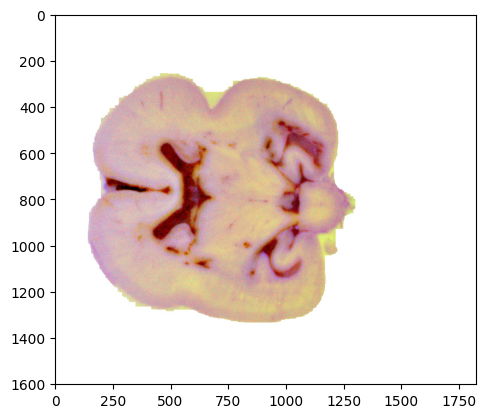

In [176]:
image_idx=1256
image1, mask, mask2 = read_img_mask(image_idx, original=False)
image_ref_cp = cp.asarray(image1)
# image_ref_cp =cucim.skimage.exposure.equalize_hist(image_ref_cp,mask=cp.asarray(mask))

plt.imshow(image_ref_cp.get())

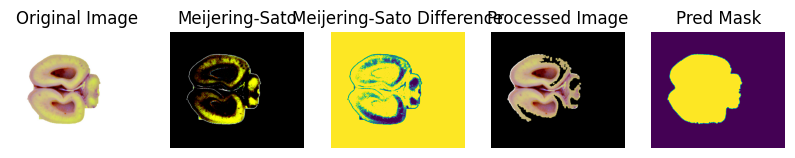

In [319]:
import cucim
import cucim.skimage
import cucim.core
import cupy as cp
from skimage import feature, exposure

image_idx=1867


image, mask, mask2 = read_img_mask(image_idx, original=False)
image_cp = cp.asarray(image)
# image_ref_cp = cp.asarray(image1)
# image_cp = cucim.skimage.exposure.equalize_hist(image_cp, nbins=256, mask=cp.asarray(mask))
# image_cp = cucim.skimage.exposure.match_histograms(image_cp.astype(cp.uint8), image_ref_cp, channel_axis=2)
# fig,ax = plt.subplots(1,2,figsize=(10,5))
# ax[0].imshow(image_cp.get())
# ax[1].imshow(image)
image_cp_min = cp.min(image_cp, axis=2)
# img_features = cucim.skimage.feature.multiscale_basic_features(image_cp, intensity=False, edges=False, texture=True, sigma_min=1.2, sigma_max=2, num_sigma=5, channel_axis=2)
# img_min = np.min(image, axis=2)
# lbp = feature.local_binary_pattern(img_min, 15, 10, method='uniform')
sato = cucim.skimage.filters.sato(image_cp,sigmas=np.linspace(0.1,3,10),black_ridges=False)
sato = (sato-cp.min(sato))/(cp.max(sato)-cp.min(sato))
meijering = cucim.skimage.filters.meijering(image_cp,sigmas=np.linspace(0.1,3,10), black_ridges=False)
s =(((1-cp.abs(meijering-sato))<0.82)*255).astype(cp.uint8).get()
# ax[0].imshow()
# ms_dif = (s[:,:,2]+s[:,:,1])/2
ms_dif = np.ones_like(s[:,:,1])*255 - s[:,:,1]
crumbs =  (ms_dif==0).astype(np.uint8)*255

# ms_dif = cv2.GaussianBlur(ms_dif, (3,3), 3)
contours,_  = cv2.findContours(ms_dif, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
blank = np.zeros_like(ms_dif).astype(np.uint8)
blank = cv2.fillPoly(blank, contours, 255)
blank = (blank==0).astype(np.uint8)
blank = cv2.dilate(blank, np.ones((3,3), np.uint8), iterations=3)
mask[(mask==1) & (blank==1)] = 0
mask = ndi.binary_fill_holes(mask)
# mask = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_OPEN, np.ones((3,3), np.uint8), iterations=10)
mask = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_CROSS, np.ones((3,3), np.uint8), iterations=10)
mask = ndi.binary_fill_holes(mask)
img__ = cv2.bitwise_and(image, image, mask=mask.astype(np.uint8))
# ms_dif = np.linalg.norm(s[:,:,:2], axis=2)
# md_dif = ms_dif - ms_dif.max()
fig, ax = plt.subplots(1, 5, figsize=(10, 10))
ax[0].imshow(image_cp.get())
ax[0].axis("off")
ax[0].set_title("Original Image")
ax[1].imshow(s)
ax[1].axis("off")
ax[1].set_title("Meijering-Sato")
ax[2].imshow(ms_dif)
ax[2].axis("off")
ax[2].set_title("Meijering-Sato Difference")
ax[3].imshow(img__)
ax[3].axis("off")
ax[3].set_title("Processed Image")
mask2 = cv2.morphologyEx(mask2, cv2.MORPH_CLOSE, np.ones((3,3), np.uint8), iterations=5)
ax[4].imshow(ndi.binary_fill_holes(mask2))
ax[4].axis("off")
ax[4].set_title("Pred Mask")
plt.show()

In [442]:
plt.ioff( )

In [443]:
from skimage.color import separate_stains
def plot_channels(image, channels,axes):
    # fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for i, (channel, name) in enumerate(zip(cv2.split(channels), ["C1", "C2", "C3"])):
        channel = process_channel(channel)
        channel = extract_img(image, channel)
        axes[i].imshow(channel)
        axes[i].set_title(f'{name} Channel ({channel.min()}-{channel.max()})')
        axes[i].axis("off")

image_idx=39

image, mask, mask2 = read_img_mask(image_idx, original=False)
stain_refs = [ahx_from_rgb,hpx_from_rgb,bpx_from_rgb,bro_from_rgb,hax_from_rgb,gdx_from_rgb,rbd_from_rgb,bex_from_rgb,fgx_from_rgb,hdx_from_rgb,hed_from_rgb]
stain_refs+=[get_stain_vector(i) for i in range(1,21)]
fig, ax = plt.subplots(31,3, figsize=(15, 90))
for i,stain_ref in enumerate(stain_refs):
    stain = separate_stains(image, stain_ref)
    plot_channels(image, stain, ax[i])
plt.tight_layout()
plt.savefig(f"stains_separation_{image_idx}.png")

In [ ]:

for stain_ref in stain_refs:
    channels = separate_stains(image, stain_ref)
    plot_channels(image, channels)


In [305]:
refmu = [150,150,150]
refsd = [50, 55, 65]
def match_mu_sd(im, ref_mu=refmu, ref_sd=refsd):
    out = im.copy()
    for ch in range(3):
        mu = im[...,ch].mean()
        sd = im[...,ch].std()
        
        out[...,ch]=np.clip(((out[...,ch]-mu)/sd*ref_sd[ch])+ref_mu[ch],10,255)
    return out

# if biosampleid=='213': 

# plt.imshow(blank)

In [340]:
import numpy as np


def convert_RGB_to_OD(I):
    """
    Convert from RGB to optical density (OD_RGB) space.

    RGB = 255 * exp(-1*OD_RGB).

    :param I: Image RGB uint8.
    :return: Optical denisty RGB image.
    """
    mask = (I == 0)
    I[mask] = 1
    return np.maximum(-1 * np.log(I / 255), 1e-6)


def convert_OD_to_RGB(OD):
    """
    Convert from optical density (OD_RGB) to RGB.

    RGB = 255 * exp(-1*OD_RGB)

    :param OD: Optical denisty RGB image.
    :return: Image RGB uint8.
    """
    assert OD.min() >= 0, "Negative optical density."
    OD = np.maximum(OD, 1e-6)
    return (255 * np.exp(-1 * OD)).astype(np.uint8)

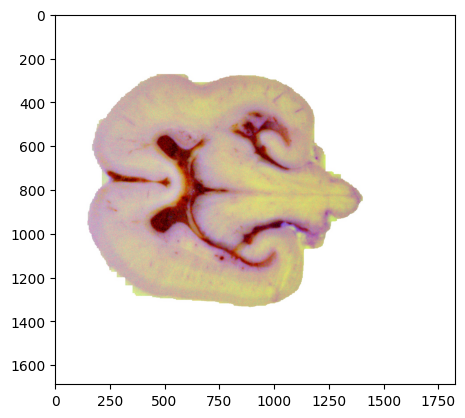

In [430]:
# decrease gamma
image_idx=1405

image, mask, mask2 = read_img_mask(image_idx, original=False)
image_cp = cp.asarray(image) 
# image_cp = cucim.skimage.exposure.equalize_adapthist(image_cp, kernel_size=8)
# image_cp = cucim.skimage.filters.hessian(image_cp,sigmas=range(1, 3, 2), scale_range=None, scale_step=None, alpha=0.8, beta=0.2, gamma=5, black_ridges=False, mode='reflect', cval=0)
plt.imshow(image_cp.get())
# plt.imshow(image)

In [371]:
abs_im = cucim.core.operations.color.image_to_absorbance(image_cp, )

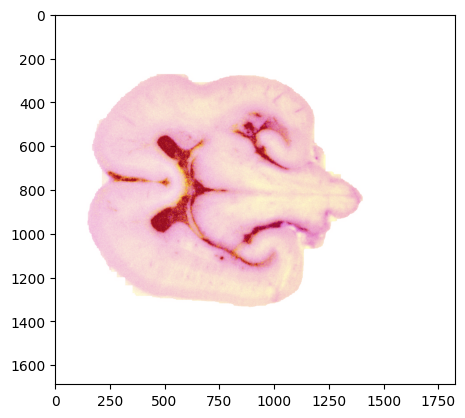

In [435]:
import cucim.core.operations.color
image_idx=1405

image, mask, mask2 = read_img_mask(image_idx, original=False)
# image_cp = cp.asarray(image) 

# stain_pca  = cucim.core.operations.color.stain_extraction_pca(image_cp, source_intensity=255, alpha=0.9, beta=.03, channel_axis=2, image_type='intensity')
# stain_image_cp = cucim.core.operations.color.normalize_colors_pca(image=image_cp.astype(np.uint8), alpha=0.9, beta=.03, ref_stain_coeff=stain_pca, source_intensity=255,channel_axis=2)
# plt.imshow(stain_image_cp.get())



In [362]:
image_cp.shape

(1574, 1828, 3)

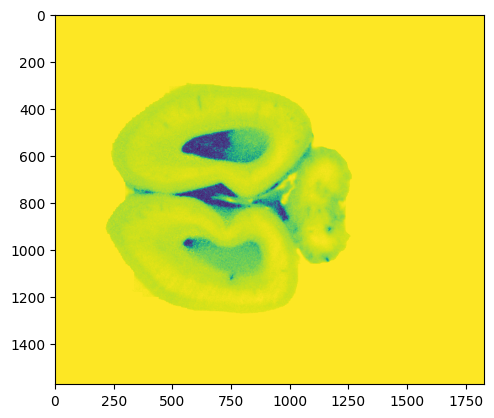

In [169]:
import cucim.core.operations
import cucim.core.operations.color

image_idx=1606

image, mask, mask2 = read_img_mask(image_idx, original=False)
image_cp = cp.asarray(image)
abs_img = cucim.core.operations.color.image_to_absorbance(image_cp)
abs_img = (abs_img-cp.min(abs_img))/(cp.max(abs_img)-cp.min(abs_img))


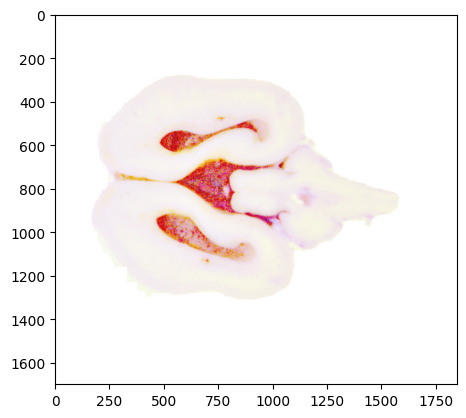

In [171]:
plt.imshow((1-abs_img).get())

In [ ]:

channels = separate_stains(image, get_stain_vector(10))
plot_channels(image, channels)
plot_current_masks(image, mask, mask2)
ddog = background_removal_dog(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY),15,27)
plt.imshow(ddog)
plt.title('DoG')
plt.axis('off')
plt.show()

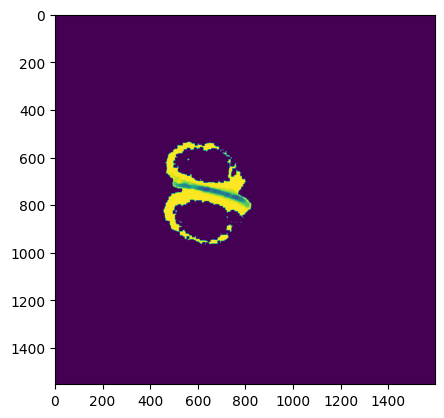

In [ ]:
(np.min(image,axis=2)/255)
image_idx=55

image, mask, mask2 = read_img_mask(image_idx, original=False)
np.percentile(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)/255, [0, 2, 4, 8, 20])
im_min = np.min(image,axis=2)/255
im_min[im_min>0.6]=0
im_min = (im_min*255).astype(np.uint8)
# im_min = cv2.dilate(im_min, np.ones((3,3), np.uint8), iterations=2)
im_min = cv2.morphologyEx(im_min.astype(np.uint8), cv2.MORPH_CLOSE, np.ones((3,3), np.uint8), iterations=5)
# im_min = ndi.binary_fill_holes(im_min)
plt.imshow(im_min)

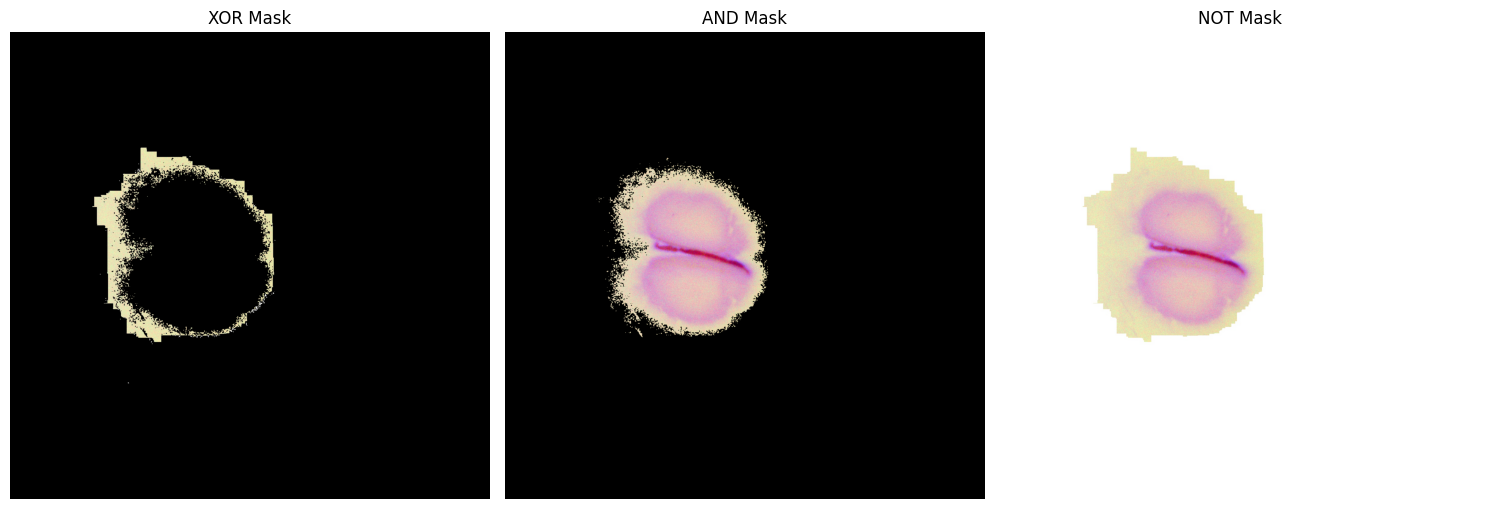

In [ ]:
image_idx=55

image, mask, mask2 = read_img_mask(image_idx, original=False)
mask_xor = np.bitwise_xor(mask, mask2)
mask_and = np.bitwise_and(mask, mask2)
mask_not = np.bitwise_not(mask)
image_trim_xor = cv2.bitwise_and(image, image, mask=mask_xor.astype(np.uint8))
image_trim_and = cv2.bitwise_and(image, image, mask=mask_and.astype(np.uint8))
image_trim_not = cv2.bitwise_and(image, image, mask=mask_not.astype(np.uint8))
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(image_trim_xor)
axes[0].set_title("XOR Mask")
axes[0].axis("off")
axes[1].imshow(image_trim_and)
axes[1].set_title("AND Mask")
axes[1].axis("off")
axes[2].imshow(image_trim_not)
axes[2].set_title("NOT Mask")
axes[2].axis("off")
plt.tight_layout()
plt.show()
# image_trim = cv2.morphologyEx(image_trim, cv2.MORPH_OPEN, np.ones((3,3), np.uint8), iterations=5)
# plt.imshow(np.min(image_trim, axis=2))

In [ ]:
im_min = np.min(image,axis=2)/255
threshold = 1.0
((im_min < threshold).mean() + (im_min <= threshold).mean()) / 2

0.5595752501020742

In [ ]:
 np.arange(0, 100, 10)

array([ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90])

In [ ]:
image, mask, mask2 = read_img_mask(image_idx, original=False)
im_min = np.min(image,axis=2)/255
np.percentile(im_min[mask==1], np.arange(0, 100, 5))

array([0.        , 0.58039216, 0.60784314, 0.61568627, 0.62352941,
       0.63137255, 0.63529412, 0.63921569, 0.64313725, 0.64705882,
       0.65098039, 0.65490196, 0.65882353, 0.6627451 , 0.66666667,
       0.6745098 , 0.67843137, 0.68235294, 0.69019608, 0.69803922])

In [ ]:
np.percentile(im_min[mask==0], np.arange(0, 110, 10))

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

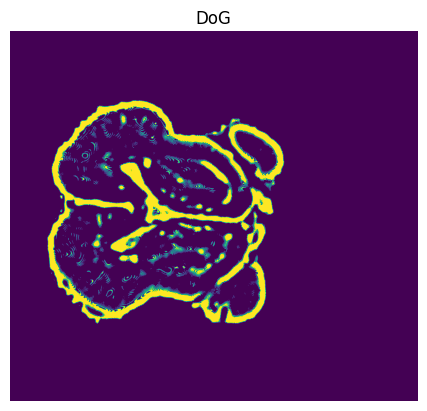

In [ ]:
ddog = background_removal_dog(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY),55,67)
plt.imshow(ddog)
plt.title('DoG')
plt.axis('off')
plt.show()

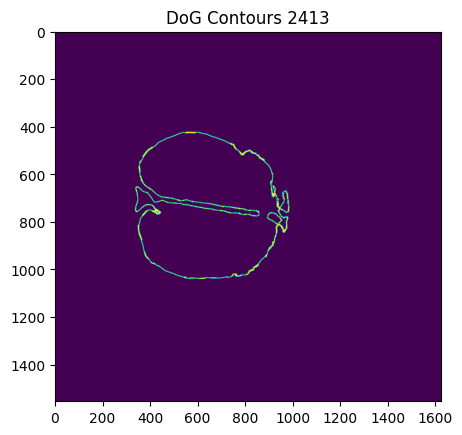

In [ ]:
# ddog = background_removal_dog(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY),15,27)
contours,_ = cv2.findContours(ddog, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)
blank = np.zeros_like(ddog, dtype=np.uint8)

contour_img = cv2.drawContours(blank, contours, 1, 1, 2)
plt.imshow(contour_img)
plt.title(f'DoG Contours {len(contours)}')
plt.show()

In [ ]:
import os
import cv2
brightfield = os.listdir('213_BFIW/BFIW/')
darkfield = os.listdir('213_BFIW/BFI/')
brightfield = sorted(brightfield, key=lambda x: int(x.replace('_original.jpg','').split('_')[-1]))
darkfield = sorted(darkfield, key=lambda x: int(x.replace('_original.jpg','').split('_')[-1]))
slides = {}
for bf, df in zip(brightfield, darkfield):
    idx = bf.replace('_original.jpg','').split('_')[-1]
    slides[int(idx)] = {'brightfield': bf, 'darkfield': df}

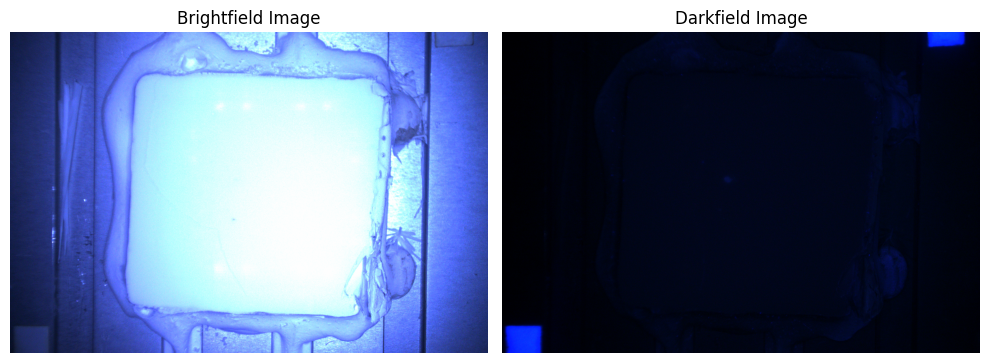

In [ ]:
slide_idx = 2655
bfiw = slides[slide_idx]['brightfield']
bfi = slides[slide_idx]['darkfield']
flatfield_bfiw_img = cv2.imread(f'213_BFIW/BFIW/{bfiw}')
flatfield_bfi_img = cv2.imread(f'213_BFIW/BFI/{bfi}')
flatfield_bfiw_img = cv2.cvtColor(flatfield_bfiw_img, cv2.COLOR_BGR2RGB)
flatfield_bfi_img = cv2.cvtColor(flatfield_bfi_img, cv2.COLOR_BGR2RGB)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(flatfield_bfiw_img)
axes[0].set_title('Brightfield Image')
axes[0].axis('off')
axes[1].imshow(flatfield_bfi_img)
axes[1].set_title('Darkfield Image')
axes[1].axis('off')
plt.tight_layout()